# Studying PCA-RF classifier with the MNIST dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

### Data prep
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

### Modeling
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [2]:
# Some common settings
pd.set_option('max_columns', None)
pd.set_option('max_rows', 100)

# Some common variables
PATH_DATA = "./datasets"

## Get the dataset

In [3]:
!kaggle competitions download -c digit-recognizer -p {PATH_DATA}

digit-recognizer.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip -n {PATH_DATA}/digit-recognizer.zip -d {PATH_DATA}

Archive:  ./datasets/digit-recognizer.zip


In [5]:
# Read the data into _raw np array
train_raw = np.loadtxt(f'{PATH_DATA}/train.csv', skiprows=1, delimiter=',')
X_test_raw = np.loadtxt(f'{PATH_DATA}/test.csv', skiprows=1, delimiter=',')

# Check the shape
print(train_raw.shape, X_test_raw.shape)

(42000, 785) (28000, 784)


In [6]:
# Training set
X = train_raw[:, 1:].copy()
y = train_raw[:, 0].copy()  # first column is label

# Test set
X_test = X_test_raw.copy()

# Check the shape
print(X.shape, y.shape, X_test.shape)

(42000, 784) (42000,) (28000, 784)


## EDA

<hr>

**Summary:** This MNIST dataset contains 42000 hand-written digits, with each a 28x28 (=784) dimension array. There is no class imbalance, nor contains any missing values.

<hr>

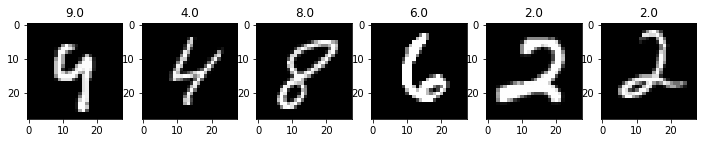

In [7]:
# Print some randomly selected digits
size = 6

fig, axes = plt.subplots(1, size, figsize=(12, 12))
for i, j in enumerate(np.random.randint(0, X.shape[0], size)):
    plt.subplot(1, size, i+1)
    plt.title(y[j])
    plt.imshow(X[j].reshape(28, 28), cmap="gray")

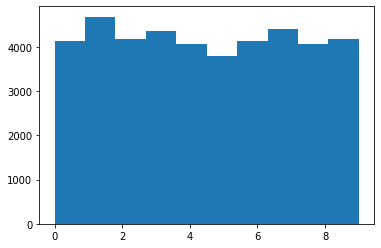

In [8]:
# How's the label distribution
plt.hist(y, bins=10)
plt.show()

In [9]:
# Any missing values?
print("Missing values in training set:", np.isnan(X).sum())
print("Missing values in test set:", np.isnan(X_test).sum())

Missing values in training set: 0
Missing values in test set: 0


## Research design

<hr>

**Summary:** We will conduct three experiments and evaluate the effects of incorporating PCA in the data preparation pipeline on a) total time required to prepare (if any) and train a random forest (RF) classifier; b) macro F1 score.

First, we perform a grid search of the best hyperparameter set for the MNIST dataset, which is `{'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 100}`. We will use this to construct the RF classifier for the whole study.

* **Experiment A, RF classifier:** We will fit the whole training set as-is into the RF model. Performance will be measured by out-of-bag (OOB) accuracy.
* **Experiment B, PCA-RF classifier:** Properly split the data into training and validation set. Then by fitting the training set with PCA to retain 95% of the variability in the explanatory variables, followed by a RF model. Performance will be measured by OOB score and also macro F1 score on the validation set.

<hr>

In [10]:
def print_grid_search_result(gs):
    """
    Print out
    * best hyperparameter set
    * best CV score
    """
    print('Best hyperparameter set: ', gs.best_params_)
    print('Best Macro F1 on CV: ', gs.best_score_)

### Experiment A: Random Forest

#### Fit the whole training set to the RF model

In [11]:
# Define the RF classifier
rf = RandomForestClassifier(n_estimators=100,
                            max_features='sqrt',
                            bootstrap=True, 
                            random_state=42,
                            oob_score=True,
                            n_jobs=-1)

In [12]:
%%time

# Measure the time to train the RF classifier
rf.fit(X, y)

CPU times: user 40.7 s, sys: 756 ms, total: 41.5 s
Wall time: 13.2 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [13]:
# Measure the accuracy from out-of-bag samples
rf.oob_score_

0.9618571428571429

#### Inference and submit to Kaggle

In [14]:
# Inference
y_test = rf.predict(X_test)

In [15]:
# Prepare file for submission
submission = pd.DataFrame({'ImageId': list(range(1, 28001, 1)),
                           'Label': y_test.astype(int)})
submission.to_csv(f'{PATH_DATA}/submission1_rf.csv', index=False)

> **Score:** 0.96371  **Time to train the model:** 11s
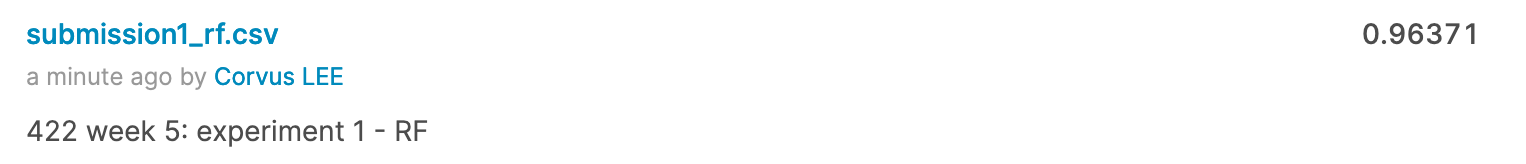

### Experiment B: PCA-RF

#### Fit and transform with PCA

In [25]:
# Training set
X = train_raw[:, 1:].copy()
y = train_raw[:, 0].copy()  # first column is label

# Test set
X_test = X_test_raw.copy()

# Check the shape
print(X.shape, y.shape, X_test.shape)

# Split into training and validation set in 3:1
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42)

print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(42000, 784) (42000,) (28000, 784)
(31500, 784) (31500,) (10500, 784) (10500,)


In [26]:
# Construct a PCA to retain .95 variance
pca = PCA(n_components=.95, random_state=42)

> Note: We didn't perform normalization on X_train as the final model performance is found to be worse.

In [27]:
%%time

# Measure the time to fit (training set only)
pca.fit(X_train)

# Measure the time to transform (training/validation/test sets)
X_train = pca.transform(X_train)
X_valid = pca.transform(X_valid)
X_test = pca.transform(X_test)

CPU times: user 5.87 s, sys: 752 ms, total: 6.63 s
Wall time: 4.13 s


In [28]:
# Verify the shape
print(X_train.shape, X_valid.shape, X_test.shape)  # (:, 153)

(31500, 153) (10500, 153) (28000, 153)


#### Fit the training set to the RF model

In [29]:
# Define the RF classifier
rf = RandomForestClassifier(n_estimators=100,
                            max_features='sqrt',
                            bootstrap=True, 
                            random_state=42,
                            oob_score=True,
                            n_jobs=-1)

In [30]:
%%time

# Measure the time to train the RF classifier
rf.fit(X_train, y_train)

CPU times: user 58 s, sys: 262 ms, total: 58.2 s
Wall time: 15.6 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [31]:
# Measure the accuracy from out-of-bag samples
rf.oob_score_

0.9271111111111111

In [32]:
# Performance on the validation set
y_pred = rf.predict(X_valid)

print(classification_report(y_valid, y_pred, digits=5))

              precision    recall  f1-score   support

         0.0    0.95989   0.98049   0.97008      1025
         1.0    0.97489   0.98255   0.97870      1146
         2.0    0.93762   0.92537   0.93146      1072
         3.0    0.91478   0.91399   0.91439      1151
         4.0    0.92885   0.94336   0.93605      1024
         5.0    0.91513   0.93653   0.92570       898
         6.0    0.95588   0.96535   0.96059      1010
         7.0    0.94835   0.93833   0.94331      1135
         8.0    0.91795   0.89055   0.90404      1005
         9.0    0.93090   0.91199   0.92135      1034

    accuracy                        0.93905     10500
   macro avg    0.93842   0.93885   0.93857     10500
weighted avg    0.93895   0.93905   0.93893     10500



**Observations:** The F1 score for digit 8 and 3 are the worst.

#### Look at some wrongly recognized digits

In [33]:
def show_wrong_digits(X_valid, y_valid, y_pred, digit, pca):
    # Show 6 images
    size = 6
    # Get the indices where the model made a wrong prediction for the specified digit
    idx = np.where((y_pred != digit) & (y_valid == digit))
    
    # Show the images and predicted labels
    fig, axes = plt.subplots(1, size, figsize=(12, 12))
    for i, j in enumerate(np.random.choice(idx[0], size, replace=False)):
        plt.subplot(1, size, i+1)
        plt.title(y_pred[j])
        # Transform X back to the original space and plot
        plt.imshow(pca.inverse_transform(X_valid[j]).reshape(28, 28), cmap="gray")

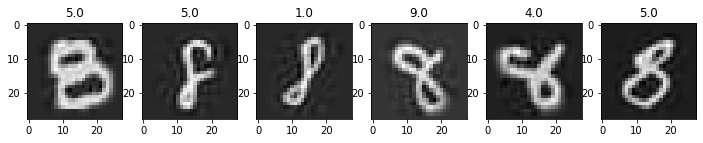

In [34]:
# Show some wrongly recognized digit 8
show_wrong_digits(X_valid, y_valid, y_pred, 8, pca)

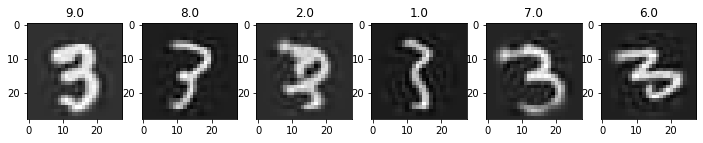

In [35]:
# Show some wrongly recognized digit 3
show_wrong_digits(X_valid, y_valid, y_pred, 3, pca)

#### Retrain combining train/validation set, inference and submit to Kaggle

In [36]:
# Training set
X = train_raw[:, 1:].copy()
y = train_raw[:, 0].copy()  # first column is label

# Test set
X_test = X_test_raw.copy()

# Check the shape
print(X.shape, y.shape, X_test.shape)

(42000, 784) (42000,) (28000, 784)


In [37]:
%%time

# Measure the time to transform
X = pca.transform(X)
X_test = pca.transform(X_test)

# Measure the time to train the RF classifier
rf.fit(X, y)

CPU times: user 1min 22s, sys: 619 ms, total: 1min 22s
Wall time: 23 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [38]:
# Inference
y_test = rf.predict(X_test)

In [39]:
# Prepare file for submission
submission = pd.DataFrame({'ImageId': list(range(1, 28001, 1)),
                           'Label': y_test.astype(int)})
submission.to_csv(f'{PATH_DATA}/submission3_pca-rf.csv', index=False)

> * **Score:** 0.94457
* **Time to identify principal components and train the model:** 22s

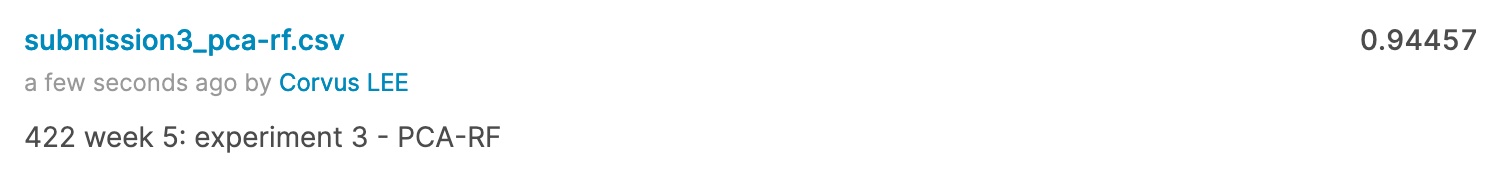

## Summary

<hr>

| Experiment | Model | Total Time | Accuracy |
| --- | --- | --- | --- |
| 1 | Random Forest | 11s | .96371 |
| 2 | PCA-RF | 22s | .94457 |

**Summary:** Comparing the two methods in the MNIST dataset, obviously Random Forest (without PCA) is the best choice. Not only it has higher accuracy, it also takes less time to train. There are a few possible reasons for this:

* Information loss
 * During the PCA process, we have lost 5% of data variance, which may cause the RF model performing worse.
* No tree pre-pruning in place
 * We allow the tress to grow as deep as it can. PCA-RF may have much deeper trees than RF in this dataset, causing a longer time to train.
 
Generally speaking, in a classification problem we can first try to train a RF model with the original data. If training speed is an issue, try tuning the RF model:

* Distribute the training task to multiple CPU cores or even multiple computers
* Apply tree pre-pruning, such as setting maximum depth, maximum leaf nodes, etc.
* Use other classifiers, such as Extra-Trees

<hr>